In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras
import tensorflow as tf

In [54]:
bbl_matches = pd.read_csv("BBL Matches 2011-2019.csv")
print("\nBBL Matches:")
print(bbl_matches.head())

# Read BBL ball-by-ball data
bbl_deliveries = pd.read_csv("BBL Ball-by-Ball 2011-2019.csv")
print("\nBBL Deliveries:")
print(bbl_deliveries.head())


BBL Matches:
       id       city        date player_of_match  \
0  524915     Sydney  2011-12-16       BJ Haddin   
1  524916  Melbourne  2011-12-17       DA Warner   
2  524917   Adelaide  2011-12-18       M Klinger   
3  524918      Perth  2011-12-18   BW Hilfenhaus   
4  524919   Brisbane  2011-12-20       RJ Quiney   

                                          venue  neutral_venue  \
0                         Sydney Cricket Ground              0   
1                      Melbourne Cricket Ground              0   
2                                 Adelaide Oval              0   
3  Western Australia Cricket Association Ground              0   
4        Brisbane Cricket Ground, Woolloongabba              0   

               team1                team2          toss_winner toss_decision  \
0      Sydney Sixers        Brisbane Heat        Brisbane Heat           bat   
1    Melbourne Stars       Sydney Thunder       Sydney Thunder         field   
2  Adelaide Strikers  Melbourne Rene

In [55]:
print(bbl_matches.columns)


Index(['id', 'city', 'date', 'player_of_match', 'venue', 'neutral_venue',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'winner', 'result',
       'result_margin', 'eliminator', 'method', 'umpire1', 'umpire2'],
      dtype='object')


In [56]:
print(bbl_deliveries.columns)


Index(['id', 'inning', 'over', 'ball', 'batsman', 'non_striker', 'bowler',
       'batsman_runs', 'extra_runs', 'total_runs', 'non_boundary', 'is_wicket',
       'dismissal_kind', 'player_dismissed', 'fielder', 'extras_type',
       'batting_team', 'bowling_team'],
      dtype='object')


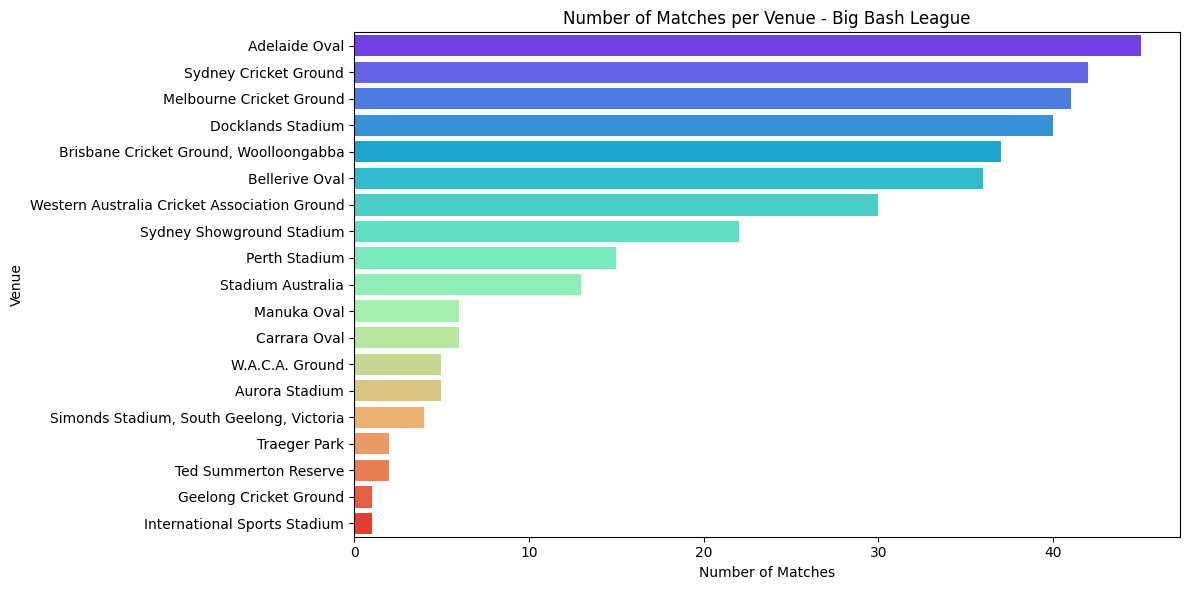

In [57]:
data = bbl_matches.copy()

# Get unique match ID and venue
matches_per_venue = data[['id', 'venue']].drop_duplicates()

# Count number of matches per venue
matches_count = matches_per_venue['venue'].value_counts()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=matches_count.values, y=matches_count.index, palette="rainbow")
plt.title('Number of Matches per Venue - Big Bash League')
plt.xlabel('Number of Matches')
plt.ylabel('Venue')
plt.tight_layout()
plt.show()


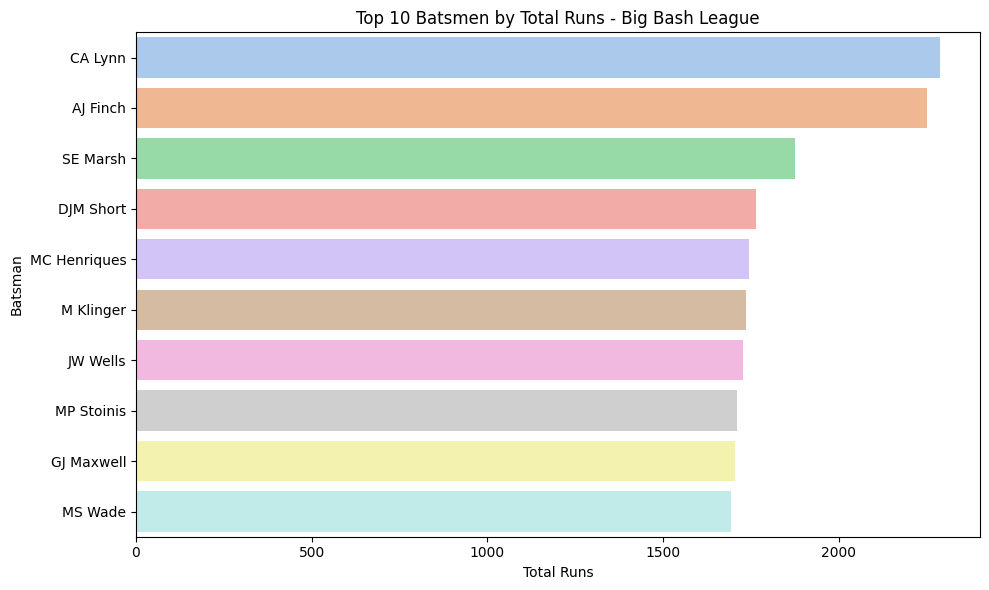

In [58]:
# Use the BBL ball-by-ball data
data = bbl_deliveries.copy()

# Group by batsman and sum runs
runs_by_batsman = data.groupby('batsman')['batsman_runs'].sum().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x=runs_by_batsman.values, y=runs_by_batsman.index, palette="pastel")
plt.title('Top 10 Batsmen by Total Runs - Big Bash League')
plt.xlabel('Total Runs')
plt.ylabel('Batsman')
plt.tight_layout()
plt.show()


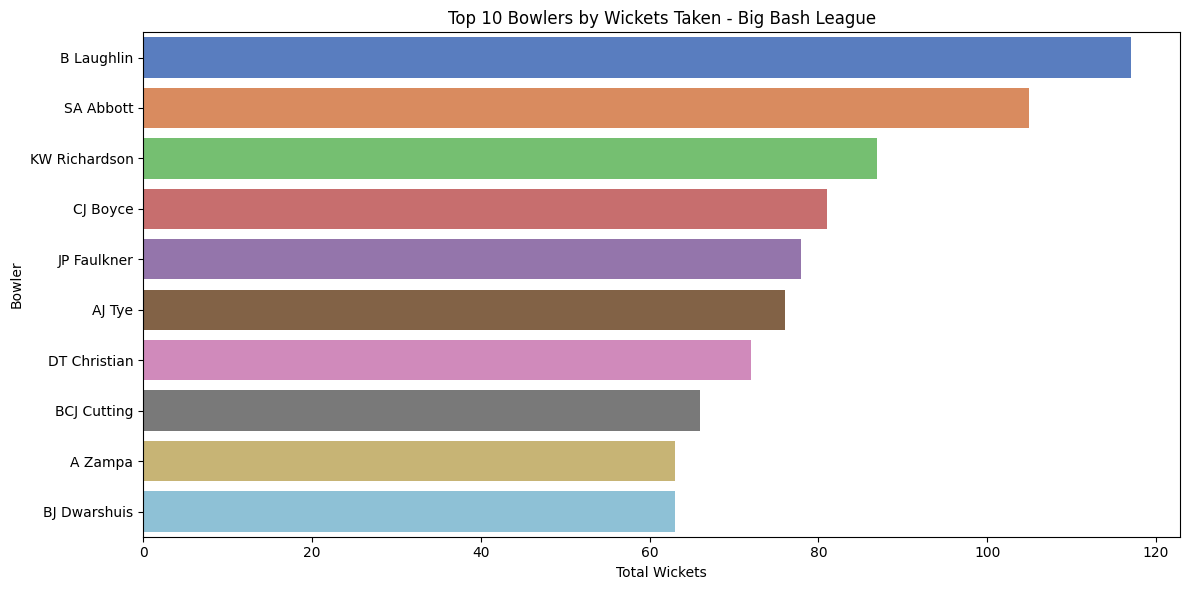

In [59]:
# Filter deliveries where a wicket was taken
wickets = bbl_deliveries[bbl_deliveries['player_dismissed'].notna()]

# Count wickets per bowler and get top 10
top_bowlers = wickets['bowler'].value_counts().head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=top_bowlers.values, y=top_bowlers.index, palette="muted")
plt.title('Top 10 Bowlers by Wickets Taken - Big Bash League')
plt.xlabel('Total Wickets')
plt.ylabel('Bowler')
plt.tight_layout()
plt.show()


In [60]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Step 1: Merge venue from bbl_matches
bbl_merged = pd.merge(bbl_deliveries, bbl_matches[['id', 'venue']], on='id', how='left')

# Step 2: Define categorical columns
cat_cols = ['batting_team', 'bowling_team', 'venue', 'batsman', 'bowler']

# Step 3: Label encode
data_encoded = bbl_merged.copy()
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])
    label_encoders[col] = le


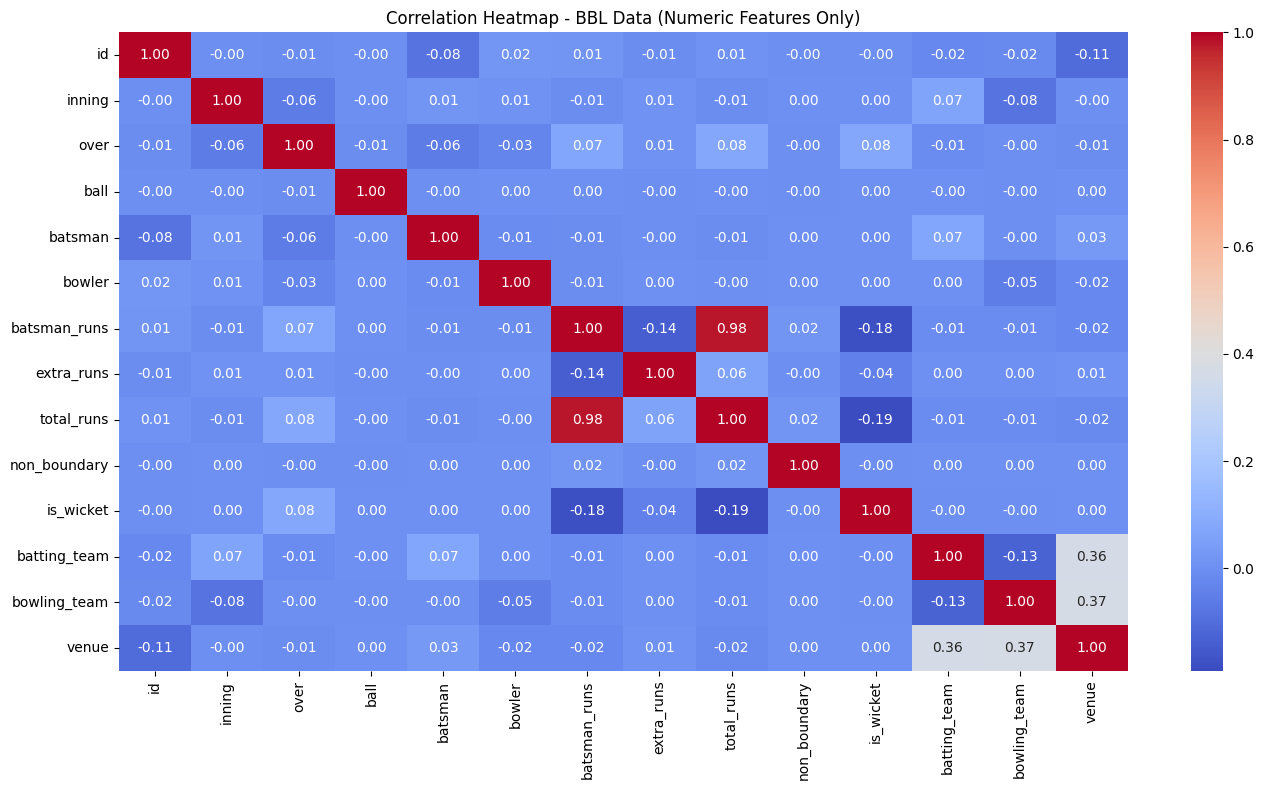

In [61]:
# Keep only numeric columns
data_corr = data_encoded.select_dtypes(include=['int64', 'float64'])

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(data_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap - BBL Data (Numeric Features Only)')
plt.tight_layout()
plt.show()


In [62]:
# Create missing columns first
data_encoded['runs'] = data_encoded['batsman_runs'] + data_encoded['extra_runs']
data_encoded['wickets'] = data_encoded['player_dismissed'].notnull().astype(int)
data_encoded['overs'] = data_encoded['over'] + 1  # Optional: 1-based over count

# Now define features and target
feature_cols = ['batting_team', 'bowling_team', 'venue', 'cum_runs', 'cum_wickets', 'overs', ]
X = model_data[feature_cols]
y = model_data['final_score']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [63]:
# Performing Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [64]:
# Build the model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(216, activation='relu'),
    keras.layers.Dense(1, activation='linear')  # Output: continuous value (e.g. total score)
])

# Robusting to outliers using huber
huber_loss = tf.keras.losses.Huber(delta=1.0)

# Compile the model
model.compile(optimizer='adam', loss=huber_loss)


In [65]:
# Traning the model
model.fit(X_train_scaled, y_train, epochs=30, batch_size=64, validation_data=(X_test_scaled, y_test))

Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 111.4952 - val_loss: 31.9218
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 27.5744 - val_loss: 17.7115
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 17.7063 - val_loss: 17.0187
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.8810 - val_loss: 16.6316
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.7400 - val_loss: 16.5767
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.2228 - val_loss: 16.0150
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.1192 - val_loss: 16.1471
Epoch 8/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.3137 - val_loss: 15.7076
Epoch 9/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.7563 - val_loss: 15.7880
Epoch 10/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.8690 - val_loss: 16.0200
Epoch 11/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.6363 - val_loss: 15.5345
Epoch 12/30
146/146 ━━━━━━━━━

In [66]:
# Final Validation loss
model.evaluate(X_test_scaled, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.8738


15.522501945495605

In [67]:
# Generate predictions and evaluate the model using MAE and MSE

from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = model.predict(X_test_scaled).flatten()

print("MAE:", mean_absolute_error(y_test, pred))
print("MSE:", mean_squared_error(y_test, pred))


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 16.01427459716797
MSE: 494.8504943847656


In [68]:
# Step 1: Group by match, inning, over
over_data = data_encoded.groupby(['id', 'inning', 'over']).agg({
    'batting_team': 'first',
    'bowling_team': 'first',
    'venue': 'first',
    'batsman': 'first',
    'bowler': 'first',
    'total_runs': 'sum',
    'player_dismissed': lambda x: x.notnull().sum()
}).reset_index()

# Step 2: Cumulative features
over_data['cum_runs'] = over_data.groupby(['id', 'inning'])['total_runs'].cumsum()
over_data['cum_wickets'] = over_data.groupby(['id', 'inning'])['player_dismissed'].cumsum()
over_data['overs'] = over_data['over'] + 1

# Step 3: Add final innings total as label
final_score = over_data.groupby(['id', 'inning'])['cum_runs'].max().reset_index()
final_score.rename(columns={'cum_runs': 'final_score'}, inplace=True)

# Step 4: Merge label
model_data = pd.merge(over_data, final_score, on=['id', 'inning'])


In [69]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
import numpy as np
warnings.filterwarnings("ignore")

# Dropdowns using BBL label encoders
venue = widgets.Dropdown(options=list(label_encoders['venue'].classes_), description='Select Venue:')
venue.style = {'description_width': 'initial'}

batting_team = widgets.Dropdown(options=list(label_encoders['batting_team'].classes_), description='Select Batting Team:')
batting_team.style = {'description_width': 'initial'}

bowling_team = widgets.Dropdown(options=list(label_encoders['bowling_team'].classes_), description='Select Bowling Team:')
bowling_team.style = {'description_width': 'initial'}

# Numeric inputs
runs = widgets.IntText(value=0, description='Runs:', style={'description_width': 'initial'})
wickets = widgets.IntText(value=0, description='Wickets:', style={'description_width': 'initial'})
overs = widgets.FloatText(value=0.0, description='Overs:', style={'description_width': 'initial'})

# Predict button
predict_button = widgets.Button(description="Predict Score")
output = widgets.Output()

# Prediction logic
def predict_score(b):
    with output:
        clear_output()

        encoded_venue = label_encoders['venue'].transform([venue.value])[0]
        encoded_batting_team = label_encoders['batting_team'].transform([batting_team.value])[0]
        encoded_bowling_team = label_encoders['bowling_team'].transform([bowling_team.value])[0]

        input_features = [
            encoded_batting_team,
            encoded_bowling_team,
            encoded_venue,
            runs.value,
            wickets.value,
            overs.value
        ]

        input_array = np.array(input_features).reshape(1, -1)
        input_array = scaler.transform(input_array)  # Assumes scaler is defined
        predicted_score = model.predict(input_array)

        print(f"Predicted Total Runs: {int(predicted_score[0])}")

predict_button.on_click(predict_score)

# Display the widget interface
display(
    venue, batting_team, bowling_team,
    runs, wickets, overs,
    predict_button, output
)


Dropdown(description='Select Venue:', options=('Adelaide Oval', 'Aurora Stadium', 'Bellerive Oval', 'Brisbane …

Dropdown(description='Select Batting Team:', options=('Adelaide Strikers', 'Brisbane Heat', 'Hobart Hurricanes…

Dropdown(description='Select Bowling Team:', options=('Adelaide Strikers', 'Brisbane Heat', 'Hobart Hurricanes…

IntText(value=0, description='Runs:', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Wickets:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Overs:', style=DescriptionStyle(description_width='initial'))

Button(description='Predict Score', style=ButtonStyle())

Output()